## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Preprocessing

In [3]:
# Direktori awal untuk train dan test
test_dir = "/content/drive/MyDrive/BIOREZ-Dataset/Dataset/test"
train_dir = "/content/drive/MyDrive/BIOREZ-Dataset/Dataset/train"

# Direktori baru untuk dataset gabungan
combined_dir = "/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset"

In [4]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [5]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

#### Data Checking

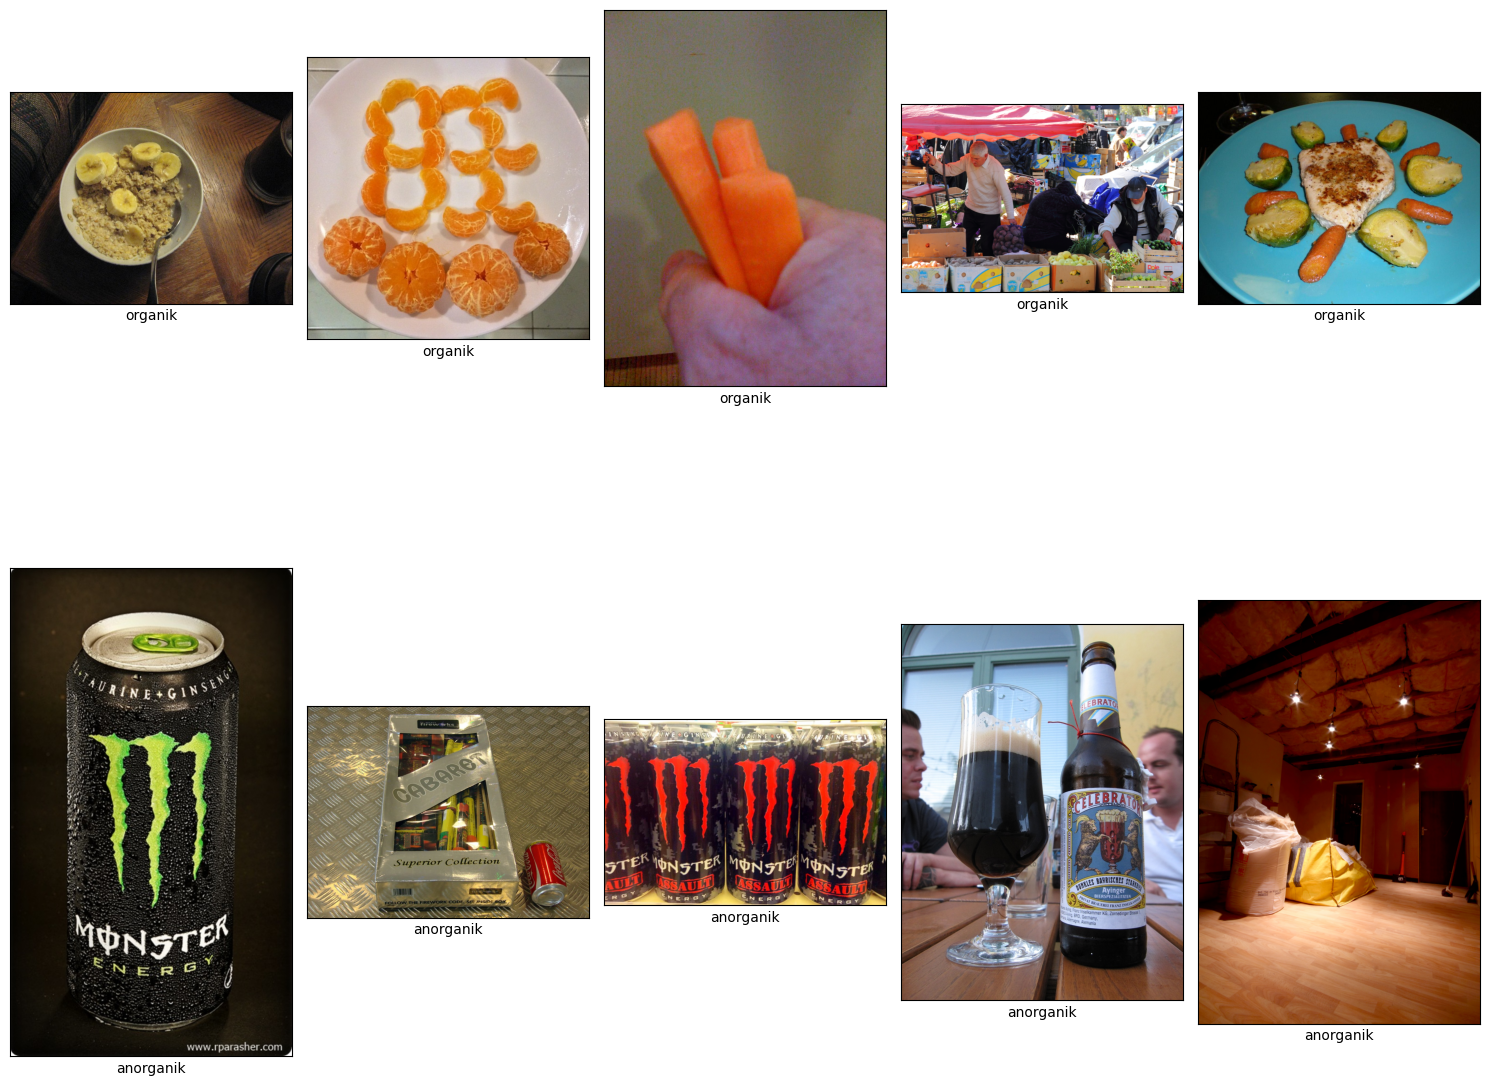

In [8]:
waste_image = {}

# Tentukan path sumber train
path = "/content/drive/MyDrive/BIOREZ-Dataset/waste/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    waste_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(waste_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(waste_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()
plt.show()

In [9]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue

        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except:
                print(f"File {img_file} bukan gambar atau tidak dapat dibuka.")

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution('/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset')
print_images_resolution('/content/drive/MyDrive/BIOREZ-Dataset/Dataset/test')
print_images_resolution('/content/drive/MyDrive/BIOREZ-Dataset/Dataset/train')

organik: 2987
- (1024, 602)
- (1024, 611)
- (1024, 849)
- (810, 1024)
- (1024, 858)
- (1023, 768)
- (1024, 705)
- (1023, 1024)
- (1024, 714)
- (772, 1024)
- (1024, 723)
- (928, 1024)
- (1024, 732)
- (1024, 570)
- (1024, 341)
- (1024, 579)
- (723, 1024)
- (1024, 826)
- (1024, 835)
- (1024, 606)
- (1024, 444)
- (685, 1024)
- (696, 1024)
- (1024, 691)
- (1024, 700)
- (1024, 947)
- (1024, 718)
- (1024, 956)
- (1024, 727)
- (764, 1024)
- (4000, 3000)
- (1024, 565)
- (889, 1024)
- (1024, 574)
- (1024, 583)
- (1024, 830)
- (1383, 1037)
- (1024, 848)
- (862, 1024)
- (611, 1024)
- (1024, 686)
- (1024, 695)
- (1024, 704)
- (1024, 713)
- (1024, 951)
- (668, 1024)
- (813, 1024)
- (1024, 960)
- (1024, 969)
- (1024, 551)
- (1024, 560)
- (881, 1024)
- (1024, 578)
- (1015, 1024)
- (1024, 816)
- (1024, 587)
- (1024, 825)
- (669, 1024)
- (1024, 834)
- (977, 768)
- (1024, 425)
- (698, 1024)
- (1024, 672)
- (1024, 681)
- (726, 1024)
- (737, 1024)
- (911, 768)
- (1024, 699)
- (1024, 946)
- (1024, 537)
- (8

#### Distribution Plot

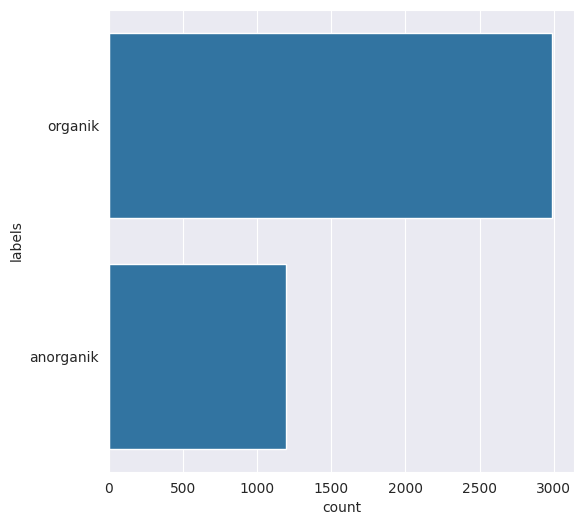

In [10]:
# Definisikan path sumber
waste_path = "/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(waste_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [13]:
def hitung_jumlah_gambar(path):
    jumlah = 0
    ekstensi_gambar = ['.jpg', '.jpeg', '.png']
    for root, dirs, files in os.walk(path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in ekstensi_gambar):
                jumlah += 1
    return jumlah

# Contoh penggunaan:
organikpath = "/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset/organik"
anorganikpath = "/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset/anorganik"
jumlah_gambar_organik = hitung_jumlah_gambar(organikpath)
jumlah_gambar_anorganik = hitung_jumlah_gambar(anorganikpath)
print(f"Jumlah total gambar di dalam folder Organik adalah: {jumlah_gambar_organik}")
print(f"Jumlah total gambar di dalam folder Anorganik adalah: {jumlah_gambar_anorganik}")

Jumlah total gambar di dalam folder Organik adalah: 2987
Jumlah total gambar di dalam folder Anorganik adalah: 1196


#### Augmentasi

In [11]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [14]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset/anorganik" #path gambar asli yang akan diaugmentasi
augmented_path="/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset/anorganik" # Path untuk gambar yang sudah diaugmentasi (langsung dimasukan kedalam folder anorganik)
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=1791
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

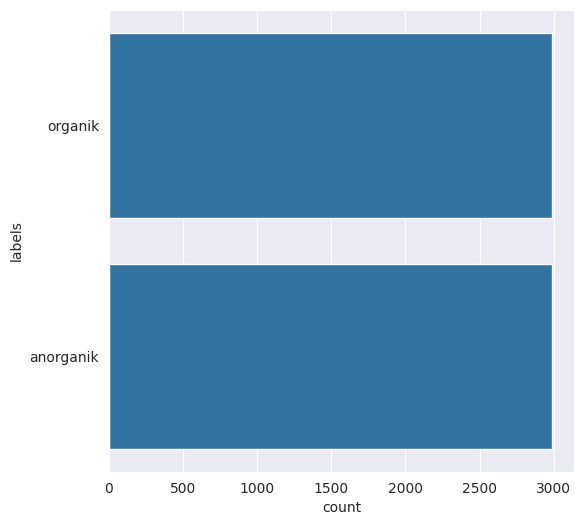

In [17]:
waste_path = "/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(waste_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Data Splitting

In [18]:
mypath= '/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
anorganik,2987
organik,2987


Setelah Augmentasi dapat dilihat bahwa Distribusi gambar sudah seimbang



In [19]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [20]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

Validation set akan dibuat nanti menggunakan ImageDataGenerator + flow_from_directory

In [23]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/content/drive/MyDrive/BIOREZ-Dataset/Dataset-Final/"


set    labels   
test   anorganik     578
       organik       617
train  anorganik    2409
       organik      2370
dtype: int64 


                                                   path     labels    set
3522  /content/drive/MyDrive/BIOREZ-Dataset/waste/da...  anorganik  train
5627  /content/drive/MyDrive/BIOREZ-Dataset/waste/da...    organik   test
4078  /content/drive/MyDrive/BIOREZ-Dataset/waste/da...  anorganik  train
3925  /content/drive/MyDrive/BIOREZ-Dataset/waste/da...    organik  train
4186  /content/drive/MyDrive/BIOREZ-Dataset/waste/da...  anorganik  train


Distribusi label dalam masing-masing set cukup seimbang, yang mengindikasikan bahwa model dapat belajar dari berbagai kategori dengan baik tanpa mengalami bias yang signifikan.


In [24]:
datasource_path = "/content/drive/MyDrive/BIOREZ-Dataset/waste/dataset/"
dataset_path = "/content/drive/MyDrive/BIOREZ-Dataset/Dataset-Final/"

for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['image'])

    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(target_dir, exist_ok=True)

    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_dir, destination_file_name)

    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

In [26]:
# Definisikan direktori training dan test
TRAIN_DIR = "/content/drive/MyDrive/BIOREZ-Dataset/Dataset-Final/train/"
TEST_DIR = "/content/drive/MyDrive/BIOREZ-Dataset/Dataset-Final/test/"

train_organik = os.path.join(TRAIN_DIR + '/organik')
train_anorganik = os.path.join(TRAIN_DIR + '/anorganik')
test_organik = os.path.join(TEST_DIR + '/organik')
test_anorganik = os.path.join(TEST_DIR + '/anorganik')

print("Total number of organik images in training set: ",len(os.listdir(train_organik)))
print("Total number of anorganik images in training set: ",len(os.listdir(train_anorganik)))
print()
print("Total number of organik images in test set: ",len(os.listdir(test_organik)))
print("Total number of anorganik images in test set: ",len(os.listdir(test_anorganik)))

Total number of organik images in training set:  2370
Total number of anorganik images in training set:  2409

Total number of organik images in test set:  617
Total number of anorganik images in test set:  578


In [27]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                             batch_size=32,
                                             target_size=(150,150),
                                             color_mode="rgb",
                                             class_mode='binary',
                                             subset='training',
                                             shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                  batch_size=32,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='binary',
                                                  subset='validation',
                                                  shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                 batch_size=1,
                                                 target_size=(150,150),
                                                 color_mode="rgb",
                                                 class_mode='binary',
                                                 shuffle=False)

Found 3824 images belonging to 2 classes.
Found 955 images belonging to 2 classes.
Found 1195 images belonging to 2 classes.


## Modeling

In [35]:
model = Sequential()

# 1st Convolutional layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                 kernel_regularizer=regularizers.l2(0.001), input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer
model.add(Conv2D(32, (4, 4), padding='same', activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer
model.add(Conv2D(32, (7, 7), padding='same', activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Flatten
model.add(Flatten())

# Dense Layers + Dropout
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile Model
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,457 (5.35 MB)

 Trainable params: 1,403,265 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [36]:
count_organik, count_anorganik = len(os.listdir(train_organik)), len(os.listdir(train_anorganik))
weight_0 = (1 / count_organik) * (count_organik + count_anorganik) / 2.0
weight_1 = (1 / count_anorganik) * (count_anorganik + count_organik) / 2.0
class_weights = {0: weight_0, 1: weight_1}

# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 61s 450ms/step - accuracy: 0.7432 - loss: 2.1338 - val_accuracy: 0.6723 - val_loss: 1.2469
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 48s 398ms/step - accuracy: 0.8169 - loss: 1.3192 - val_accuracy: 0.6513 - val_loss: 1.1233
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 58s 481ms/step - accuracy: 0.8172 - loss: 1.2101 - val_accuracy: 0.7047 - val_loss: 1.1408
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 49s 408ms/step - accuracy: 0.8404 - loss: 1.0789 - val_accuracy: 0.7445 - val_loss: 1.0639
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 48s 397ms/step - accuracy: 0.8333 - loss: 0.9031 - val_accuracy: 0.6963 - val_loss: 1.0148
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 57s 476ms/step - accuracy: 0.8506 - loss: 0.8573 - val_accuracy: 0.7351 - val_loss: 0.8864
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 49s 407ms/step - accuracy: 0.8442 - loss: 0.7104 - val_accuracy: 0.7539 - val_loss: 0.8427
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 56s 467ms/step - accuracy: 0.8624 - loss: 0

## Evaluasi dan Visualisasi

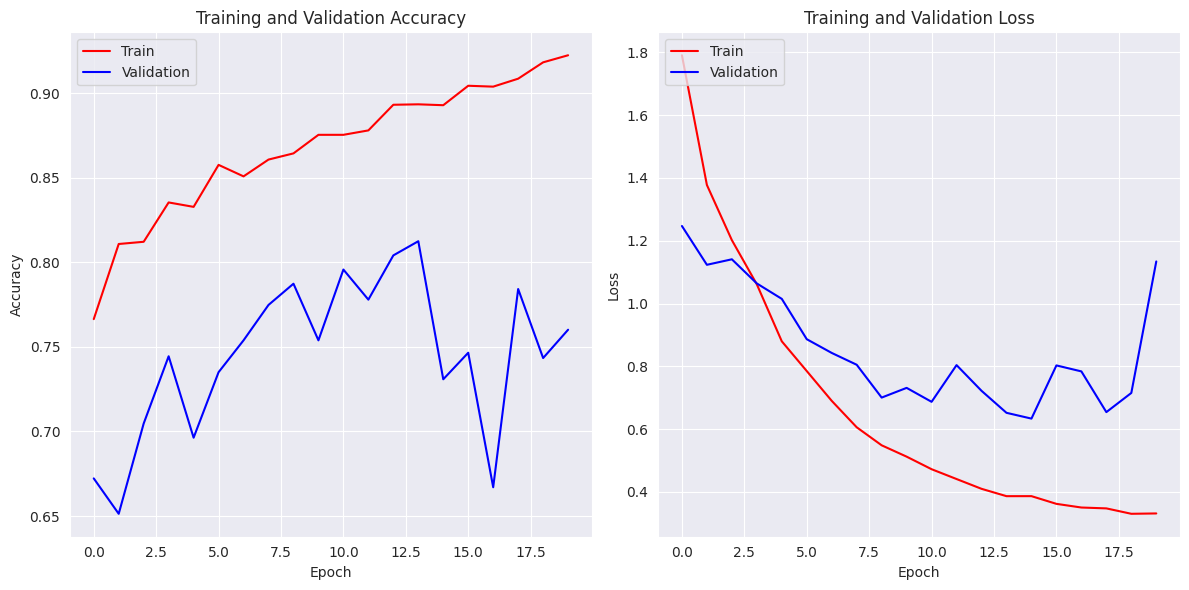

In [37]:
# Plot Training and Validation Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



              precision    recall  f1-score   support

     Organik     0.9008    0.7855    0.8392       578
   Anorganik     0.8205    0.9190    0.8670       617

    accuracy                         0.8544      1195
   macro avg     0.8607    0.8522    0.8531      1195
weighted avg     0.8594    0.8544    0.8535      1195



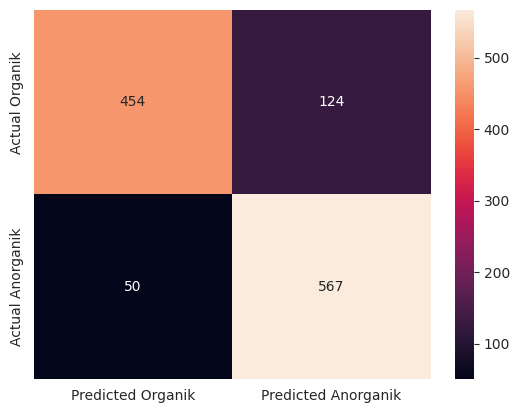

In [39]:
test_generator.reset()

preds_1 = model.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Organik", "Actual Anorganik"],
columns=["Predicted Organik", "Predicted Anorganik"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Organik','Anorganik'], digits=4))

## Konversi model

In [40]:
!pip install packaging==24.2

In [41]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [43]:
model.save("biorez.h5")

save_path = "saved_model/"
tf.saved_model.save(model, save_path)


In [44]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/ tfjs_model/


2025-06-01 15:28:28.521761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748791708.558643   37578 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748791708.569572   37578 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-01 15:28:36.070344: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748791716.070536   37578 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [45]:
saved_model_dir = "/content/saved_model"

# Konversi langsung dari direktori SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter.experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Simpan model TFLite
output_directory = "tflite"
os.makedirs(output_directory, exist_ok=True)
tflite_model_path = os.path.join(output_directory, "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Simpan label
labels = ['damage', 'no damage']
labels_file_path = os.path.join(output_directory, "labels.txt")
with open(labels_file_path, "w") as f:
    for label in labels:
        f.write(label + "\n")


In [46]:
!cp -r tfjs_model /content/drive/MyDrive/BIOREZ-Dataset/

In [47]:
!cp -r tflite /content/drive/MyDrive/BIOREZ-Dataset/

In [48]:
!cp -r saved_model /content/drive/MyDrive/BIOREZ-Dataset/